In [2]:
from matplotlib import rcParams
rcParams["figure.dpi"] = 120
rcParams["savefig.dpi"] = 120

import numpy as np
import matplotlib.pyplot as plt
import h5py
import glob

from astropy.io import fits
from astropy.timeseries import BoxLeastSquares as BLS

from bls import bls
import local_linear as ll

import batman #Bad-Ass Transit Model cAlculatioN
import astropy.units as u
from astropy.constants import G, R_sun, M_sun, R_jup, M_jup, R_earth, M_earth

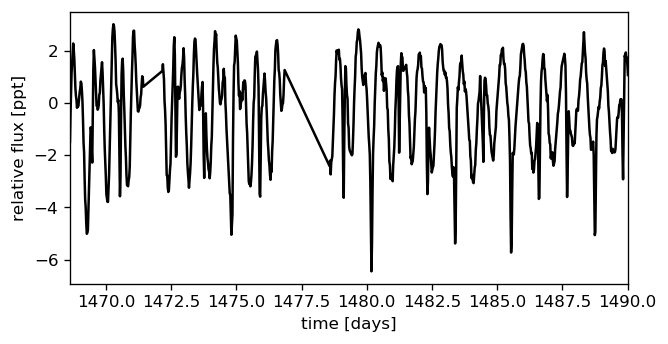

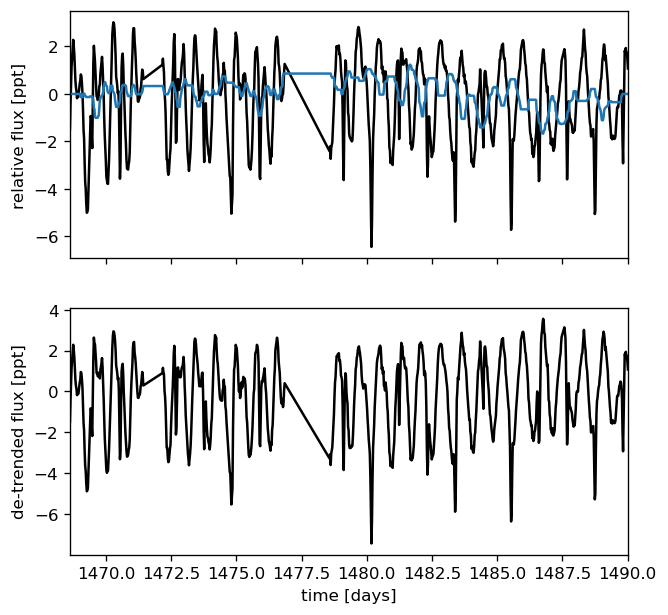

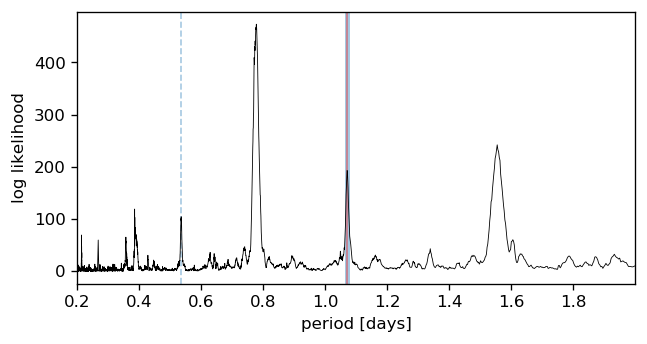

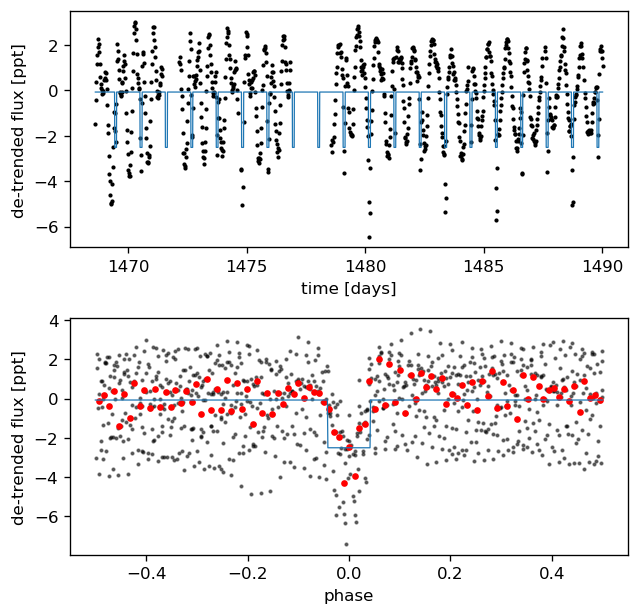

In [254]:
tess_file = 'tess_1359354.fits'#sys.argv[1]

with fits.open(tess_file) as tess_data:
    data = tess_data[1].data
    t = data["TIME"]
    y = data["SAP_FLUX"]
    q = data["QUALITY"]

# This is from the EVEREST source. These are the flagged data points
# that should be removed. Ref: https://github.com/rodluger/everest
m = np.isfinite(t) & np.isfinite(y)
for b in [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17]:
    m &= (q & (2 ** (b - 1))) == 0

t = np.ascontiguousarray(t[m], dtype=np.float64) * u.day
y = np.ascontiguousarray(y[m], dtype=np.float64)
y = (y / np.median(y) - 1)*1e3

fig, ax = plt.subplots(1, 1, sharex=True, figsize=(6, 3))
ax.plot(t, y, "k")
ax.set_xlim(t.min().value, t.max().value)
ax.set_xlabel("time [days]")
ax.set_ylabel("relative flux [ppt]");

from scipy.signal import medfilt
trend = medfilt(y, 45)
mu = np.median(y)
y_filt =(y - trend)


fig, axes = plt.subplots(2, 1, sharex=True, figsize=(6, 6))
ax = axes[0]
ax.plot(t, y, "k")
ax.plot(t, trend)
ax.set_ylabel("relative flux [ppt]")


ax = axes[1]
ax.plot(t, y_filt, "k")
ax.set_xlim(t.min().value, t.max().value)
ax.set_xlabel("time [days]")
ax.set_ylabel("de-trended flux [ppt]");

remove_outliers = (y_filt < (np.mean(y_filt) + 5.*np.std(y_filt)))&(y_filt > (np.mean(y_filt) - 5.*np.std(y_filt)))
y_rev = y_filt[remove_outliers]
t_rev = t[remove_outliers]

durations = 0.084 # 1.66 in website, 2.162 in report.
model = BLS(t_rev, y_rev)
results = model.autopower(durations, minimum_period=0.2, maximum_period=2, frequency_factor=5.0)

# Extract the parameters of the best-fit model
#index = np.argmax(results.power)
index = np.where((results.power <= 194) & (results.power >= 193))[0][0]
period = results.period[index]
t0 = results.transit_time[index]
duration = results.duration[index]

fig, ax = plt.subplots(1, 1, figsize=(6, 3))

# Highlight the harmonics of the peak period
ax.axvline(period.value, alpha=0.4, lw=3)
for n in range(2, 3):
    ax.axvline(n*period.value, alpha=0.4, lw=1, linestyle="dashed")
    ax.axvline(period.value / n, alpha=0.4, lw=1, linestyle="dashed")
ax.axvline(1.071, alpha=0.4, c='r', lw=1, linestyle="solid")

# Plot the periodogram
ax.plot(results.period, results.power, "k", lw=0.5)
#ax.set_xlim(1.06, 1.08)
#ax.set_ylim(192,194)
ax.set_xlim(results.period.min().value, results.period.max().value)
ax.set_xlabel("period [days]")
ax.set_ylabel("log likelihood");

#print(model.compute_stats(period, duration, t0))

fig, axes = plt.subplots(2, 1, figsize=(6, 6))
fig.subplots_adjust(hspace=0.3)

# Plot the light curve and best-fit model
ax = axes[0]
ax.plot(t, y, ".k", ms=3)
x = np.linspace(t.min(), t.max(), 3*len(t))
f = model.model(x, period, duration, t0)
ax.plot(x, f, lw=0.75)
ax.set_xlabel("time [days]")
ax.set_ylabel("de-trended flux [ppt]");

T0 = 2457000
epoch = 1469.474*u.d # BTJD
P = 1.071*u.d # Days

# Plot the folded data points within 0.5 days of the transit time
ax = axes[1]
x = np.mod(((t - epoch)/P)+.5, 1)-.5

#t = np.concatenate([t, lsc_jd])
#mag = np.concatenate([mag,lsc_mag])

#tau=1.3228e-8
#for i in range(len(tess_time)):
#    tess_time[i] = (tess_time[i]+T0)-i*tau
    
#tess_phase=((tess_time-epoch)%P)
#tess_phase = np.array([tess_phase[i]/P if tess_phase[i] < P/2. 
#                       else (tess_phase[i]-P)/P for i in range(len(tess_phase))])

#phase = (t - epoch) % P
#phase = np.array([phase[i]/P if phase[i] < P/2. 
#                       else (phase[i]-P)/P for i in range(len(phase))])

def spec_digitize_mean(x,y,numbins):
    mybins = np.linspace(min(x),max(x),numbins)
    digitized = np.digitize(x,mybins)
    xmeans = [np.nanmean(x[digitized==i]) for i in range(1,len(mybins))]
    ymeans= [np.nanmean(x[digitized==i]) for i in range(1,len(mybins))]
    return xmeans,ymeans

def spec_digitize_median(x,y,numbins):
    mybins = np.linspace(min(x),max(x),numbins)
    digitized = np.digitize(x,mybins)
    xmedians = [np.nanmedian(x[digitized==i]) for i in range(1,len(mybins))]
    ymedians = [np.nanmedian(y[digitized==i]) for i in range(1,len(mybins))]
    return xmedians,ymedians

binned_phase, binned_flux = spec_digitize_median(x, y_filt, 100)


#m = np.abs(x) < 0.5 * u.day
ax.plot(x, y_filt, ".k", ms=3, alpha=0.5)
ax.plot(binned_phase, binned_flux, '.r')

# Over-plot the best fit model
x = np.linspace(-0.5, 0.5, 1000) * u.day
f = model.model(x + t0, period, duration, t0)
ax.plot(x, f, lw=0.75)
ax.set_xlabel("phase")
ax.set_ylabel("de-trended flux [ppt]");

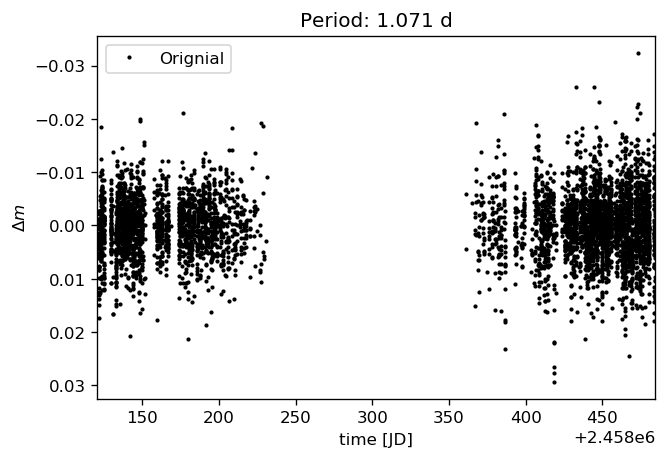

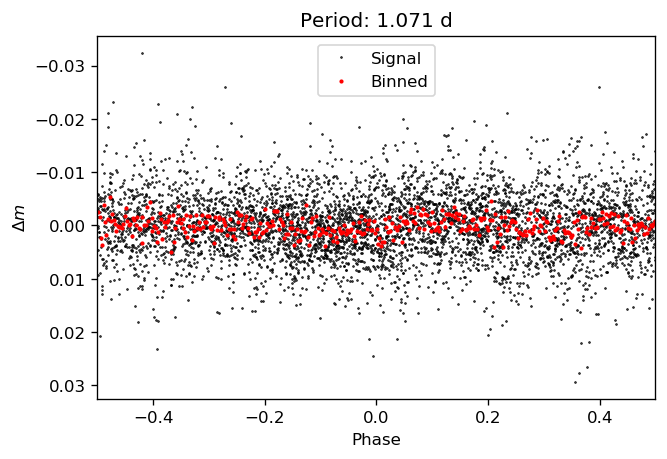

In [214]:
### Read in MASCARA data.

mascara_data_LSS = glob.glob('*LSS*')#'red0_vmag_2018Q1LSS.hdf5'
mascara_data_LSC = glob.glob('*LSC*')#sys.argv[2]
mascara_data_LSE = glob.glob('*LSE*')
mascara_data_LSW = glob.glob('*LSW*')


def get_lightcurves(mascara_data, ascc):
    
    camera = []
    for i in range(len(mascara_data)):
        camera.append(h5py.File(mascara_data[i], 'r'))
        
    lc = []
    for i in range(len(camera)):
        lc.append(camera[i]['lightcurves'][ascc][()])
        
    # Remove points binned from <=45 points.
    mask = []
    for i in range(len(lc)):
        mask.append(lc[i]['nobs'] > 45)
        lc[i] = lc[i][mask[i]]

    # Convert lst sequence to lst index.
    lstidx = []
    for i in range(len(lc)):
        lstidx.append(lc[i]['lstseq'] % 270)
        
    return lc, lstidx

#lss_lc, lss_lstidx_season = get_lightcurves(mascara_data_LSS, '1359354')
lsc_lc, lsc_lstidx_season = get_lightcurves(mascara_data_LSC, '1359354')
#lse_lc, lse_lstidx_season = get_lightcurves(mascara_data_LSE, '1359354')
#lsw_lc, lsw_lstidx_season = get_lightcurves(mascara_data_LSW, '1359354')


def collect_data(lc, idx):
    jd = []
    for i in range(len(lc)):
        jd.append(lc[i]['jd'])
    
    index = []
    for i in range(len(idx)):
        index.append(idx[i])
    
    return np.concatenate(jd) , np.concatenate(index)

lsc_jd, lsc_lstidx = collect_data(lsc_lc, lsc_lstidx_season)


### Secondary data calibriation on MASCARA by Local linear method.

def sec_cali(lc):
    
    vmag = []
    for i in range(len(lc)):
        vmag.append(lc[i]['mag0'] - ll.local_lin(lc[i]['jd'],
                                              lc[i]['lstseq'],
                                              lc[i]['x'],
                                              lc[i]['y'],
                                              lc[i]['sky'],
                                              lc[i]['mag0'],
                                              lc[i]['emag0']))
    
    return np.concatenate([vmag[0], vmag[1], vmag[2], vmag[3]])

lsc_mag = sec_cali(lsc_lc)+1


def spec_digitize_mean(x,y,numbins):
    mybins = np.linspace(min(x),max(x),numbins)
    digitized = np.digitize(x,mybins)
    xmeans = [np.nanmean(x[digitized==i]) for i in range(1,len(mybins))]
    ymeans= [np.nanmean(x[digitized==i]) for i in range(1,len(mybins))]
    return xmeans,ymeans

def spec_digitize_median(x,y,numbins):
    mybins = np.linspace(min(x),max(x),numbins)
    digitized = np.digitize(x,mybins)
    xmedians = [np.nanmedian(x[digitized==i]) for i in range(1,len(mybins))]
    ymedians = [np.nanmedian(y[digitized==i]) for i in range(1,len(mybins))]
    return xmedians,ymedians


### Signal Injection.

params = batman.TransitParams() # object to store the transit parameters
params.t0 = 0.0 # time of inferior conjunction 
params.per = 4.14 # orbital period (days)
params.rp = R_jup/R_sun # planet radius (in units of stellar radii)

# calculate semi-major axis from orbital period value
a = (((params.per*u.day)**2 * G * (M_sun + M_jup) / (4*np.pi**2))**(1./3)).to(R_sun).value

params.a = a # semi-major axis (in units of stellar radii)
params.inc = 87.0#*u.deg  # orbital inclination (in degrees)
params.ecc = 0.#*u.deg # eccentricity
params.w = 90.#*u.deg # longitude of periastron (in degrees), 90 for circular
params.u = [0.5, 0.1, 0.1, -0.1] # limb darkening coefficients
params.limb_dark = "nonlinear" # limb darkening model

#t = np.linspace(min(lsc_jd), max(lsc_jd), 10000) # times at which to calculate the light curve
m = batman.TransitModel(params, lsc_jd) # initializes the model
f = m.light_curve(params)
mag = (-2.5*np.log10(f)+1)

# add gaussian error 
#rs = np.random.RandomState(seed=17)
#errors = 0.006*np.ones_like(mag) # if comparable to the depth of the transit
#mag += errors*rs.randn(len(mag))

original_mag = lsc_mag-1
injected_mag = lsc_mag*mag-1

P = 1.071#params.per # Days

phase = np.mod(((lsc_jd) / P) + .5, 1) - .5

binned_phase, binned_mag = spec_digitize_median(phase, original_mag, 400)

plt.figure()
plt.xlim(lsc_jd.min(), lsc_jd.max())
plt.plot(lsc_jd, original_mag, '.k', ms=3, label='Orignial')
#plt.plot(lsc_jd, injected_mag, '.r', ms=1, label='Injected')
plt.gca().invert_yaxis()
plt.title("Period: {0} d".format(P))
plt.xlabel("time [JD]")
plt.ylabel(r'$\Delta m$')
plt.legend()
#plt.savefig('ascc_1359354_injected.png', dpi=200)

plt.figure()
plt.xlim(phase.min(),phase.max())
plt.plot(phase, original_mag, '.k', ms=1, label='Signal')
plt.plot(binned_phase, binned_mag, '.r', ms=3, label='Binned')
plt.gca().invert_yaxis()
plt.title("Period: {0} d".format(P))
plt.xlabel("Phase")
plt.ylabel(r'$\Delta m$')
plt.legend()
#plt.savefig('ascc_1359354_injected_phase_folding.png', dpi=200)

In [215]:
A = params.per/np.pi
B = 1/params.a
C = (1 + params.rp)**2
D = (params.a * np.cos((params.inc*u.deg).to(u.rad)))**2
E = 1 - np.cos((params.inc*u.deg).to(u.rad))**2

t_T = A * np.arcsin(B * ((C - D) / E)**(1./2)).value / params.per
t_T

0.027793894884567214

In [216]:
durations = np.linspace(0.06, 0.085, 25)#t_T / P #
#model = BLS(lsc_jd, injected_mag*(-1))
model = BLS(lsc_jd, original_mag*(-1))
results = model.autopower(durations, minimum_period=0.1, maximum_period=5, frequency_factor=5.0)
print(results)

          depth: array([0.00090976, 0.00090219, 0.00092674, ..., 0.00099016, 0.00101308,
       0.00095688])
      depth_err: array([0.03296658, 0.03294794, 0.03329271, ..., 0.04221457, 0.04261417,
       0.04210299])
      depth_snr: array([0.02759645, 0.02738236, 0.02783598, ..., 0.0234553 , 0.02377329,
       0.02272723])
       duration: array([0.084, 0.084, 0.084, ..., 0.084, 0.084, 0.084])
 log_likelihood: array([0.00050074, 0.00049325, 0.000505  , ..., 0.0003152 , 0.00032278,
       0.00029621])
      objective: 'likelihood'
         period: array([0.5       , 0.50000057, 0.50000113, ..., 1.99997958, 1.99998863,
       1.99999768])
          power: array([0.00050074, 0.00049325, 0.000505  , ..., 0.0003152 , 0.00032278,
       0.00029621])
   transit_time: array([0.21313264, 0.43258048, 0.13402769, ..., 0.82948146, 1.68926502,
       0.57905884])


[False False False False]


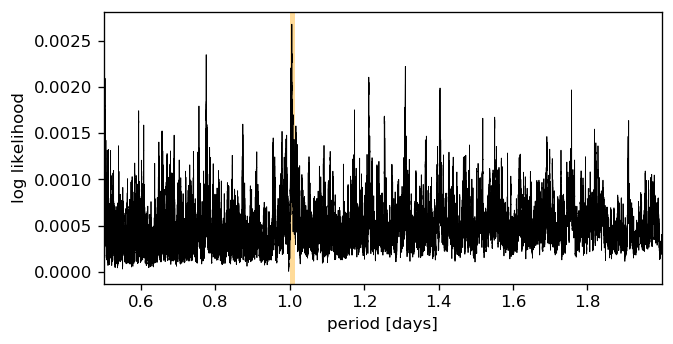

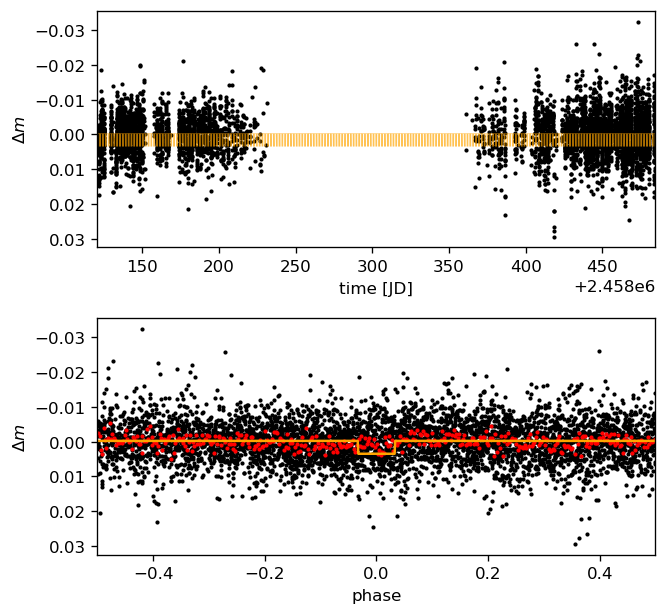

In [221]:
# Find the period of the peak
period = results.period[np.argmax(results.power)]

fig, ax = plt.subplots(1, 1, figsize=(6, 3))

# Highlight the harmonics of the peak period
ax.axvline(period, alpha=0.4, lw=3, c='orange')
for n in range(2, 4):
    ax.axvline(n*period, alpha=0.4, lw=1, linestyle="dashed", c='orange')
    ax.axvline(period / n, alpha=0.4, lw=1, linestyle="dashed", c='orange')

# Plot the periodogram
ax.plot(results.period, results.power, "k", lw=0.5)
ax.set_xlim(results.period.min(), results.period.max())
ax.set_xlabel("period [days]")
ax.set_ylabel("log likelihood");

# Signal recovery test
def signal_recovery_test(p_inj, p_rec, N=np.array([1, 2, 1/2, 1/3])):
    return (abs(p_inj - N*p_rec)/p_inj) < 1.e-3

#signal_recovery_test(params.per, period)
print(signal_recovery_test(P, period))

# Extract the parameters of the best-fit model
index = np.argmax(results.power)
period = results.period[index]
t0 = results.transit_time[index]
duration = results.duration[index]

# Set plotting configurations
fig, axes = plt.subplots(2, 1, figsize=(6, 6))
fig.subplots_adjust(hspace=0.3)

# Plot the light curve and best-fit model
ax = axes[0]
ax.plot(lsc_jd, original_mag, ".k", ms=3)
x = np.linspace(lsc_jd.min(), lsc_jd.max(), 3*len(lsc_jd))
f = model.model(x, period, duration, t0)*(-1)
ax.plot(x, f, lw=0.2, c='orange')
ax.set_xlim(lsc_jd.min(), lsc_jd.max())
ax.invert_yaxis()
ax.set_xlabel("time [JD]")
ax.set_ylabel(r'$\Delta m$');

# Plot the folded data points within 0.5 days of the transit time
ax = axes[1]
ax.plot(phase, original_mag, ".k", ms=3)
ax.plot(binned_phase, binned_mag, '.r', ms=3, label='Binned')

# Over-plot the best fit model
x = np.linspace(phase.min(), phase.max(), 1000)
f = model.model(x + t0, period, duration, t0)*(-1)
ax.plot(x, f, lw=1.5, c='orange')
ax.set_xlim(phase.min(), phase.max())
ax.invert_yaxis()
ax.set_xlabel("phase")
ax.set_ylabel(r'$\Delta m$');